In [ ]:
import os
import pandas as pd
from collections import defaultdict

### Ratios read length vs cell type

In [ ]:
# Define mapping of sample IDs to cell types
cell_type_mapping = {
    "SRR6795684": "CD5B",
    "SRR6795685": "CD5B",
    "SRR6795688": "NB",
    "SRR6795689": "NB",
    "SRR6795691": "M",
    "SRR6795693": "GC",
    "SRR6795692": "GC"
}

# Add the 'cell_type' column
result_df["cell_type"] = result_df["sample"].map(cell_type_mapping)

In [ ]:
# Define color palette for consistent cell type coloring
unique_cell_types = result_df["cell_type"].unique()
palette = sns.color_palette("tab10", len(unique_cell_types))
cell_type_colors = {cell_type: palette[i] for i, cell_type in enumerate(unique_cell_types)}

# Update the plotting function
def plot_ratios_with_lines(df, ratio_col, title, ax):
    # Plot lines connecting points for each sample, coloring by cell type
    for sample in unique_samples:
        sample_data = df[df["sample"] == sample]
        cell_type = sample_data["cell_type"].iloc[0]  # Get the cell type for this sample
        ax.plot(
            sample_data["group"],  # X-axis (group)
            sample_data[ratio_col],  # Y-axis (ratio values)
            marker="o",
            color=cell_type_colors[cell_type],  # Color by cell type
            label=cell_type if cell_type not in [h.get_label() for h in ax.get_legend_handles_labels()[0]] else ""
        )
    ax.set_title(title)
    ax.set_xticks(sorted(df["group"].unique()))
    ax.set_xticklabels(["Read length < 36", "36-42", "43-45", "46-48", "49-51"])
    ax.set_ylabel("Ratio")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

# Update the legend for cell types
handles, labels = [], []
for cell_type, color in cell_type_colors.items():
    handles.append(plt.Line2D([], [], color=color, marker="o", linestyle="", label=cell_type))
fig.legend(handles=handles, loc="lower center", ncol=5, title="Cell Types", bbox_to_anchor=(0.5, -0.1))

### IQR plots

In [16]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm  

import statsmodels.formula.api as smf

def calculate_iqr(read_lengths):
    """Calculates the Interquartile Range (IQR) of a list of read lengths.

    Args:
        read_lengths: A list of string representations of read lengths.

    Returns:
        The IQR of the read lengths.
    """

    read_lengths = [int(length) for length in read_lengths]
    return np.percentile(read_lengths, 75) - np.percentile(read_lengths, 25)

def process_file(filename):
    """Processes a single BED file.

    Args:
        filename: The path to the BED file.

    Returns:
        A pandas DataFrame containing the processed data.
    """

    df = pd.read_csv(filename, sep='\t', header=None)
    df.columns = ['chr', 'start', 'end', 'id', 'count', 'strand', 'read_lengths', 'read_ids']

    # Split the read lengths into a list
    df['read_lengths'] = df['read_lengths'].str.split(',')

    # Calculate the IQR for each row
    df['iqr'] = df['read_lengths'].apply(calculate_iqr)

    return df

def fit_quantile_regression(df):
    """Fits a quantile regression model and marks the lower 10% of points.

    Args:
        df: A pandas DataFrame containing the data.

    Returns:
        None
    """

    # Fit the quantile regression model
    mod = smf.quantreg('iqr ~ count', data=df)
    res = mod.fit(q=0.1)  # Fit the 10th percentile quantile regression

    # Predict the values
    df['predicted_iqr'] = res.predict()

    # Create a scatter plot, color-coding the lower 10% of points
    ax=sns.scatterplot(x=np.log2(df['count']), y=df['iqr'], hue=df['iqr'] <= df['predicted_iqr'], palette=['blue', 'red'], alpha=1, s=10)
    ax.set(ylim=(0, 30))
    plt.xlabel('Log2(Count)')
    plt.ylabel('IQR of Read Lengths')
    plt.title('IQR vs. Count with 10% Quantile Regression')
    plt.legend(title='Below 10th Percentile')
    plt.show()

    return res

In [17]:
SRR6795684_df = process_file("results/1202_Mayr_GT/SRR6795684_results/SRR6795684.3pSites.counts.bed")

In [69]:
SRR6795685_df = process_file("results/1202_Mayr_GT/SRR6795685_results/SRR6795685.3pSites.counts.bed")

In [70]:
SRR6795688_df = process_file("results/1202_Mayr_GT/SRR6795688_results/SRR6795688.3pSites.counts.bed")

In [71]:
SRR6795689_df = process_file("results/1202_Mayr_GT/SRR6795689_results/SRR6795689.3pSites.counts.bed")

In [72]:
SRR6795691_df = process_file("results/1202_Mayr_GT/SRR6795691_results/SRR6795691.3pSites.counts.bed")

In [73]:
SRR6795692_df = process_file("results/1202_Mayr_GT/SRR6795692_results/SRR6795692.3pSites.counts.bed")

In [74]:
SRR6795693_df = process_file("results/1202_Mayr_GT/SRR6795693_results/SRR679569.3pSites.counts.bed")

In [37]:
def plot_binned_iqr(df):
    """Plots IQRs of read lengths binned by count ranges.

    Args:
        df: A pandas DataFrame containing the data.

    Returns:
        None
    """

    # Bin the counts into log2 scale ranges
    bins = list(range(1,17))  # Define bins
    df['count_bins'] = pd.cut(np.log2(df['count'] + 1), bins=bins, right=False)

    # Create a boxplot for each bin
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='count_bins', y='iqr', data=df, palette='vlag')
    
    plt.xlabel('Log2(Count) Bins')
    plt.ylabel('IQR of Read Lengths')
    plt.title('Boxplot of IQR by Count Bins')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

/scratch/balajt0000/slurm-job.19484070/ipykernel_2210159/4214299517.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='count_bins', y='iqr', data=df, palette='vlag')


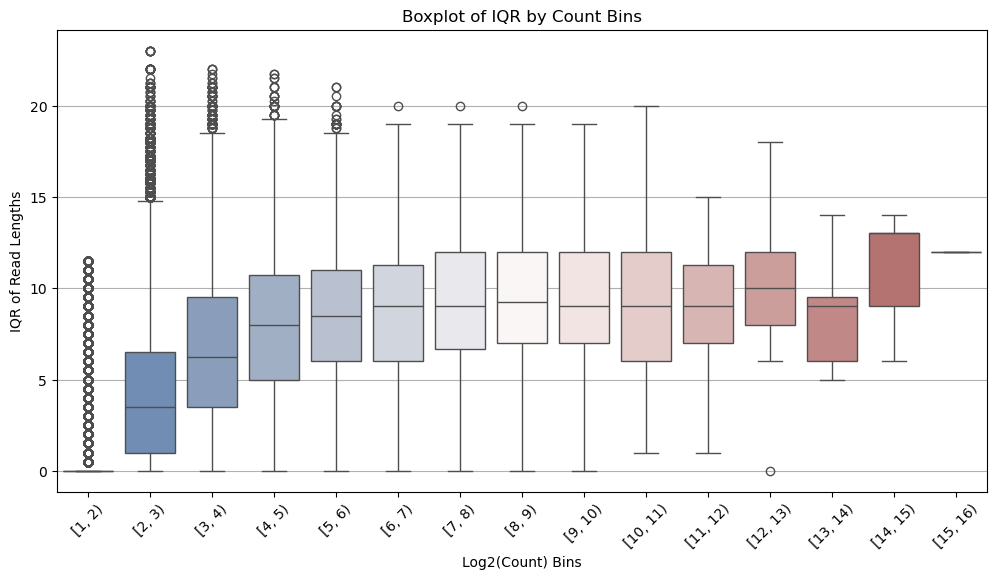

In [38]:
plot_binned_iqr(SRR6795684_df)

In [87]:
def plot_binned_iqr_with_log2_bins_and_smoothing(df, sample_name):
    """Plots IQRs of read lengths binned by log2(count) and overlays a rolling lower 10% quantile of IQR.

    Args:
        df: A pandas DataFrame containing the data.

    Returns:
        None
    """

    # Step 1: Define bins based on log2 scale
    bins = list(range(1, 17))  # Log2 bins from 2^1 to 2^16
    df['log2_count'] = np.log2(df['count'])
    df['count_bins'] = pd.cut(df['log2_count'], bins=bins, right=False)

    # Step 2: Calculate the 10th percentile (lower quantile) for each bin
    quantiles = df.groupby('count_bins')['iqr'].quantile(0.1).reset_index(name='10th_percentile')

    # Debugging output to check calculated quantiles
    print("Quantiles:\n", quantiles)

    # Step 3: Calculate rolling lower 10% quantile for smoothing
    rolling_window = 3  # Rolling window size
    quantiles['smoothed_10th_percentile'] = quantiles['10th_percentile'].rolling(rolling_window, center=True, min_periods=1).mean()

    # Step 4: Create a boxplot for each bin
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='count_bins', y='iqr', data=df)

    # Step 5: Overlay the original and smoothed 10th percentiles
    plt.scatter(
        x=range(len(quantiles)),  # Position of bins
        y=quantiles['10th_percentile'],
        color='red',
        label='10th percentile (Per bin)'
    )
    plt.plot(
        range(len(quantiles)),  # Position of bins
        quantiles['smoothed_10th_percentile'],
        color='blue',
        label='10th percentile (smoothed with rolling window)'
    )

    plt.xlabel('Log2(count of reads)')
    plt.ylabel('IQR of read lengths')
    plt.title(f"IQR by Log2(Count) with 10th Percentile - {sample_name}")
    plt.xticks(range(len(quantiles)), labels=quantiles['count_bins'].astype(str), rotation=45)
    plt.grid(axis='y')
    plt.legend()
    plt.savefig(f"{sample_name}_IQR_10_quantile.png", dpi=100, bbox_inches='tight')
    plt.show()


/scratch/balajt0000/slurm-job.19484070/ipykernel_2210159/3961054861.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby('count_bins')['iqr'].quantile(0.1).reset_index(name='10th_percentile')


Quantiles:
    count_bins  10th_percentile
0      [1, 2)             0.00
1      [2, 3)             0.00
2      [3, 4)             1.50
3      [4, 5)             2.25
4      [5, 6)             3.00
5      [6, 7)             4.00
6      [7, 8)             4.00
7      [8, 9)             4.90
8     [9, 10)             4.50
9    [10, 11)             4.00
10   [11, 12)             4.00
11   [12, 13)             6.60
12   [13, 14)             5.70
13   [14, 15)             7.20
14   [15, 16)            12.00


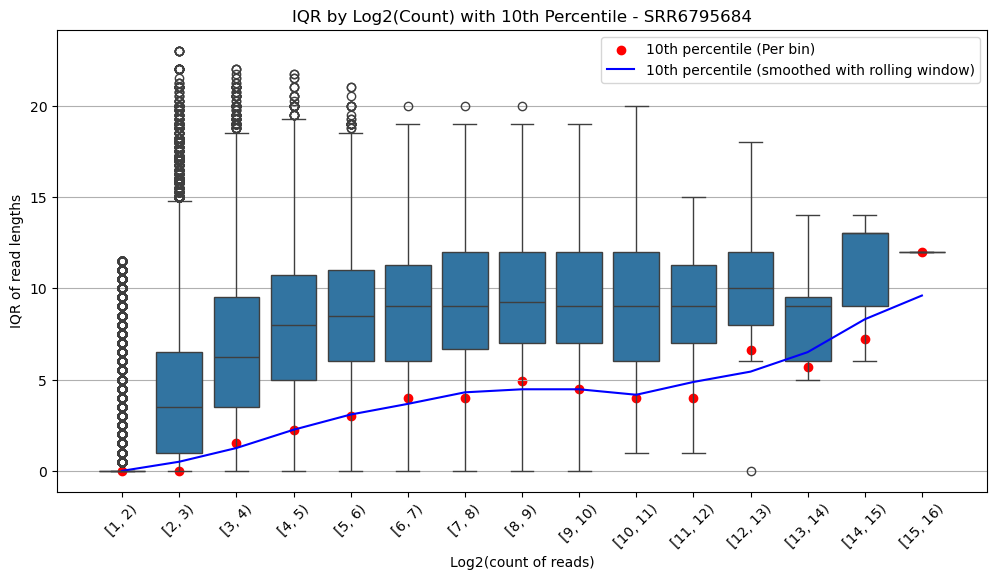

In [88]:
plot_binned_iqr_with_log2_bins_and_smoothing(SRR6795684_df, "SRR6795684")

/scratch/balajt0000/slurm-job.19484070/ipykernel_2210159/3961054861.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby('count_bins')['iqr'].quantile(0.1).reset_index(name='10th_percentile')


Quantiles:
    count_bins  10th_percentile
0      [1, 2)            0.000
1      [2, 3)            0.000
2      [3, 4)            1.500
3      [4, 5)            2.250
4      [5, 6)            3.000
5      [6, 7)            4.000
6      [7, 8)            4.000
7      [8, 9)            4.575
8     [9, 10)            4.225
9    [10, 11)            4.000
10   [11, 12)            4.400
11   [12, 13)            6.100
12   [13, 14)            4.600
13   [14, 15)           11.200
14   [15, 16)            6.200


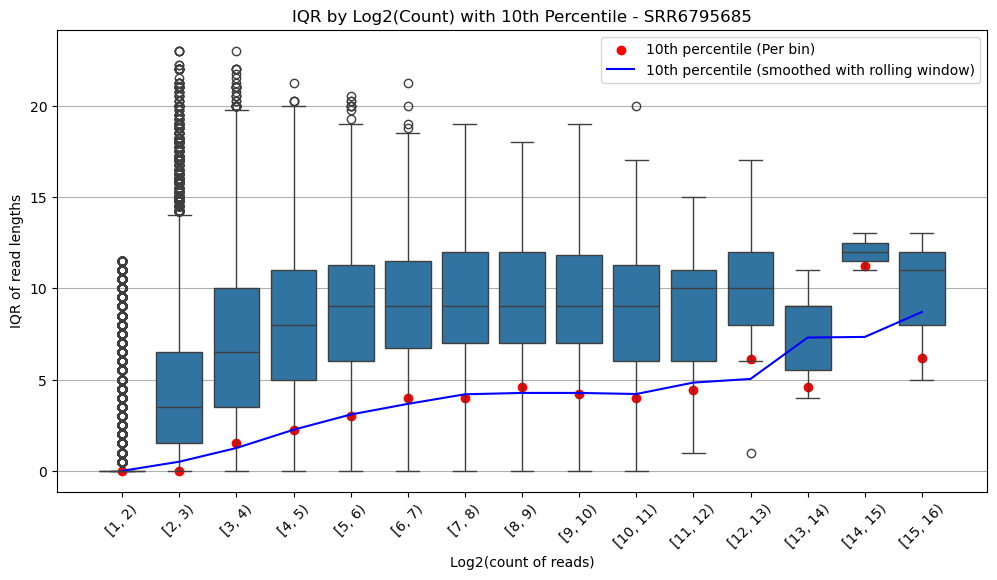

In [89]:
plot_binned_iqr_with_log2_bins_and_smoothing(SRR6795685_df, "SRR6795685")

/scratch/balajt0000/slurm-job.19484070/ipykernel_2210159/4169788403.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby('count_bins')['iqr'].quantile(0.1).reset_index(name='10th_percentile')


Quantiles:
    count_bins  10th_percentile
0      [1, 2)             0.00
1      [2, 3)             0.25
2      [3, 4)             1.75
3      [4, 5)             3.00
4      [5, 6)             3.25
5      [6, 7)             4.00
6      [7, 8)             4.00
7      [8, 9)             4.00
8     [9, 10)             5.00
9    [10, 11)             4.00
10   [11, 12)             4.00
11   [12, 13)             3.60
12   [13, 14)             6.90
13   [14, 15)             6.20
14   [15, 16)              NaN


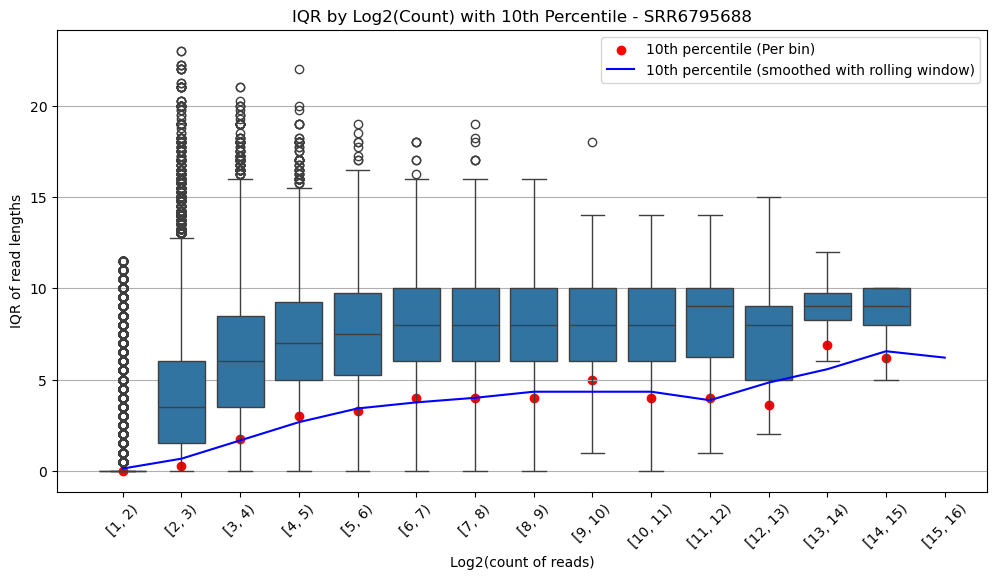

In [83]:
plot_binned_iqr_with_log2_bins_and_smoothing(SRR6795688_df, "SRR6795688")

In [108]:
def plot_binned_iqr_with_quantile_bins_and_smoothing(df, sample_name):
    """Plots IQRs of read lengths binned by quantiles of `count` and overlays a rolling lower 10% quantile of IQR.

    Args:
        df: A pandas DataFrame containing the data.

    Returns:
        None
    """

    # Step 1: Define bins based on quantiles of `count`
    num_bins = 100  # Number of quantile bins (10% bins)
    df['count_bins'], bin_edges = pd.qcut(df['count'], q=num_bins, retbins=True, duplicates='drop')

    # Step 2: Calculate the 10th percentile (lower quantile) for each bin
    quantiles = df.groupby('count_bins')['iqr'].quantile(0.1).reset_index(name='10th_percentile')

    # Debugging output to check calculated quantiles
    print("Quantiles:\n", quantiles)

    # Step 3: Calculate rolling lower 10% quantile for smoothing
    rolling_window = 3  # Rolling window size
    quantiles['smoothed_10th_percentile'] = quantiles['10th_percentile'].rolling(rolling_window, center=True, min_periods=1).mean()

    # Step 4: Create a boxplot for each bin
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='count_bins', y='iqr', data=df, order=quantiles['count_bins'])

    # Step 5: Overlay the original and smoothed 10th percentiles
    plt.scatter(
        x=range(len(quantiles)),  # Position of bins
        y=quantiles['10th_percentile'],
        color='red',
        label='10th Percentile (per bin)'
    )
    plt.plot(
        range(len(quantiles)),  # Position of bins
        quantiles['smoothed_10th_percentile'],
        color='blue',
        label='10th Percentile (Smoothed with Rolling Window)'
    )

    plt.xlabel('Count Bins (Quantile-Based)')
    plt.ylabel('IQR of read lengths')
    plt.title(f"IQR by Log2(Count) with 10th Percentile - {sample_name}")
    plt.xticks(range(len(quantiles)), labels=quantiles['count_bins'].astype(str), rotation=45)
    plt.grid(axis='y')
    plt.legend()
    plt.savefig(f"{sample_name}_IQR_10_quantile.png", dpi=100, bbox_inches='tight')
    plt.show()


/scratch/balajt0000/slurm-job.19484070/ipykernel_2210159/3577768931.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby('count_bins')['iqr'].quantile(0.1).reset_index(name='10th_percentile')


Quantiles:
          count_bins  10th_percentile
0      (0.999, 2.0]             0.00
1        (2.0, 3.0]             0.00
2        (3.0, 4.0]             0.50
3        (4.0, 5.0]             0.00
4        (5.0, 6.0]             0.75
5        (6.0, 7.0]             1.50
6        (7.0, 8.0]             1.25
7        (8.0, 9.0]             1.00
8       (9.0, 12.0]             1.75
9      (12.0, 15.0]             2.00
10     (15.0, 21.0]             2.00
11     (21.0, 33.0]             3.00
12     (33.0, 70.0]             3.00
13  (70.0, 45691.0]             4.00


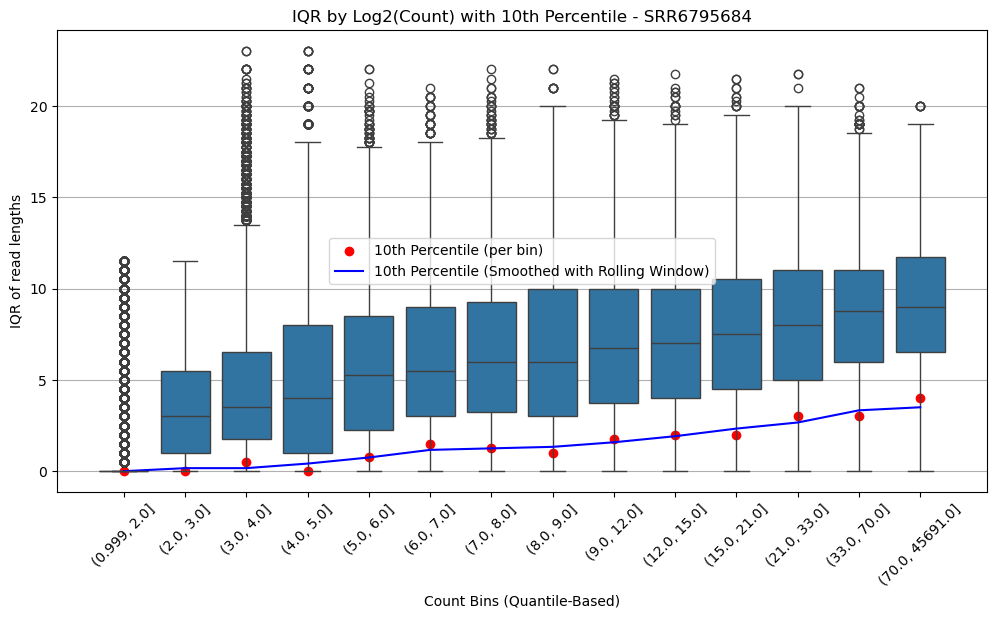

In [109]:
plot_binned_iqr_with_quantile_bins_and_smoothing(SRR6795684_df, "SRR6795684")

/scratch/balajt0000/slurm-job.19484070/ipykernel_2210159/3577768931.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby('count_bins')['iqr'].quantile(0.1).reset_index(name='10th_percentile')


Quantiles:
          count_bins  10th_percentile
0      (0.999, 2.0]             0.00
1        (2.0, 3.0]             0.00
2        (3.0, 4.0]             0.50
3        (4.0, 5.0]             0.00
4        (5.0, 6.0]             0.75
5        (6.0, 7.0]             1.50
6        (7.0, 9.0]             1.25
7       (9.0, 11.0]             1.75
8      (11.0, 14.0]             2.00
9      (14.0, 20.0]             2.00
10     (20.0, 32.0]             3.00
11     (32.0, 68.0]             3.50
12  (68.0, 41783.0]             4.00


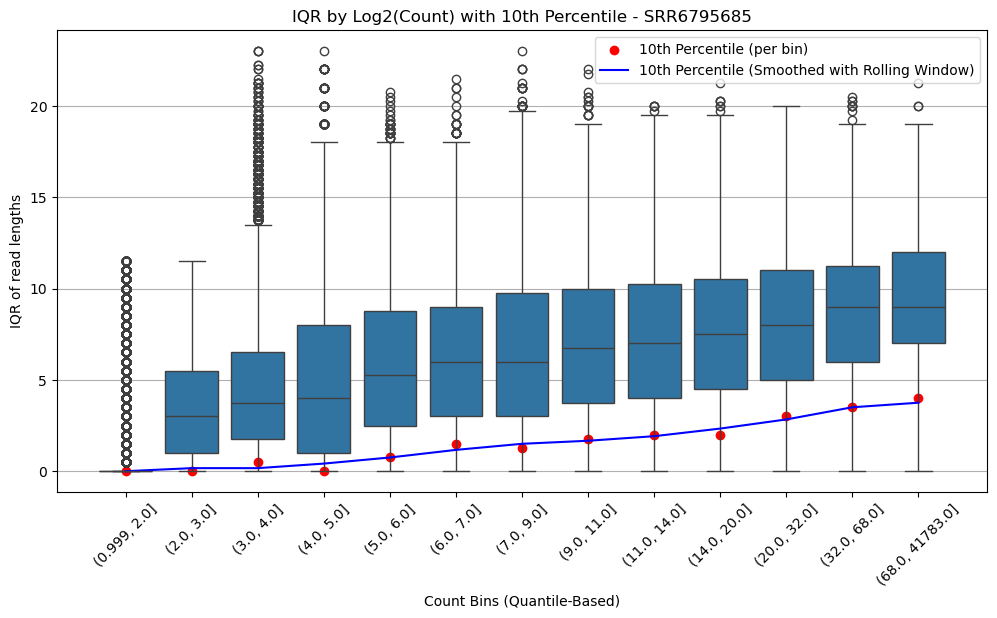

In [110]:
plot_binned_iqr_with_quantile_bins_and_smoothing(SRR6795685_df, "SRR6795685")